In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from transformers import BertModel, BertTokenizer

/opt/homebrew/Caskroom/miniforge/base/envs/cq1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


type
0    428103
1     96457
3     94111
2     32520
Name: count, dtype: int64


<Axes: xlabel='type', ylabel='count'>

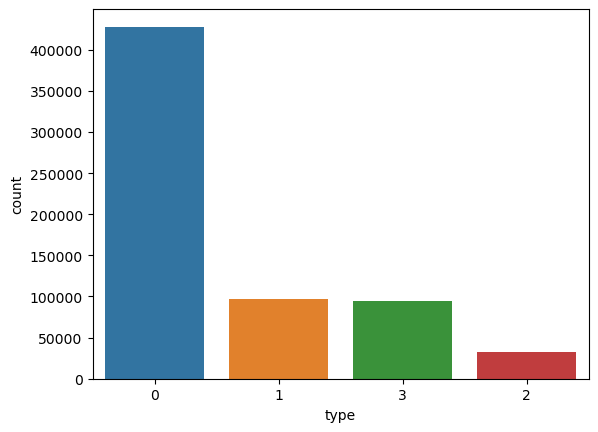

In [3]:
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('/Users/qiaochufeng/Desktop/Cam/Bert/phish_full.csv')
df_train = df[:1000]
df_val = df[1000:1100]
cat_cols = df.select_dtypes(include=['object']).columns.tolist() # ['url', 'type']
le = LabelEncoder() # Initialize the LabelEncoder
encoded_data = le.fit_transform(df['type']) # Fit and transform the data into [0, 1, 2, 3]
df['type'] = encoded_data
class_counts = df['type'].value_counts()
print(class_counts) 
%matplotlib inline
sns.countplot(x = 'type', data = df, order = df['type'].value_counts().index)

In [5]:
# Load the pre-trained BERT model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# Define a function to extract features for each transaction
def extract_features(text): 
    input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]) # Tokenize the text
    with torch.no_grad(): # Get the hidden states for each token
        outputs = model(input_ids)
        hidden_states = outputs[2]
    token_vecs = [] # Concatenate the last 4 hidden states
    for layer in range(-4, 0):
        token_vecs.append(hidden_states[layer][0])
    features = [] # Calculate the mean of the last 4 hidden states
    for token in token_vecs:
        features.append(torch.mean(token, dim=0))
    return torch.stack(features) # Return the features as a tensor

In [9]:
# Extract features for each transaction
features = []
df = df_train
for i in range(len(df)):
    features.append(extract_features(df.iloc[i]["url"]))
features = torch.cat(features).numpy() # Concatenate the features and convert to a numpy array
types = df['type'].values
print(features.shape) # features is a 2D numpy array of size 4000x768
print(types.shape) # labels is a 1D numpy array of size 1000

(4000, 768)
(1000,)


In [10]:
# reshape the feature array to size 1000x(768*4)
features_reshaped = features.reshape((1000, -1))
# concatenate the feature array with the label array horizontally
dataset = np.hstack((features_reshaped, types.reshape((-1, 1))))
# dataset is a 2D numpy array of size 1000x(4000*768+1)
features_reshaped.shape

(1000, 3072)

In [11]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
X_train, y_train = train_data[:, :-1], train_data[:, -1] # array
X_test, y_test = test_data[:, :-1], test_data[:, -1] # array

In [13]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
sm = SMOTE(random_state=42)

# Fit SMOTE to training data
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

y_train_s = pd.Series(y_train)
y_train_res = pd.Series (y_train_res)

# Print class distribution of original and resampled data
print('Class distribution before resampling:', y_train_s.value_counts())
print('Class distribution after resampling:', y_train_res.value_counts())

Class distribution before resampling: benign        593
defacement    138
phishing       45
malware        24
Name: count, dtype: int64
Class distribution after resampling: benign        593
defacement    593
phishing      593
malware       593
Name: count, dtype: int64


In [14]:
from sklearn.linear_model import LogisticRegression
# Train a logistic regression classifier on the training set
clf = LogisticRegression()
clf.fit(X_train, y_train)
# Evaluate the classifier on the testing set
score = clf.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.96


/opt/homebrew/Caskroom/miniforge/base/envs/cq1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
# Predict the labels of the testing set
y_pred = clf.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
# Generate the confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", cr)



Confusion Matrix:
 [[140   0   0   1]
 [  1  41   1   0]
 [  1   1   4   1]
 [  1   1   0   7]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.98      0.99      0.99       141
  defacement       0.95      0.95      0.95        43
     malware       0.80      0.57      0.67         7
    phishing       0.78      0.78      0.78         9

    accuracy                           0.96       200
   macro avg       0.88      0.82      0.85       200
weighted avg       0.96      0.96      0.96       200



In [1]:
import shap
import torch
import json
import numpy as np
import scipy as sp
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
def load_model(model_path):
    # Load the tokenizer and model from the "roberta-base" pre-trained model
    tokenizer = AutoTokenizer.from_pretrained("roberta-base",use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained("roberta-base").cuda()
    # Load the saved state dict of the fine-tuned model
    model.load_state_dict(torch.load(model_path))
    return tokenizer, model

tokenizer = tokenizer
model = clf

def main():
    # Load the fine-tuned model from the saved state dict
    print(tokenizer.model_max_length)
    labels = ["negative", "positive"]

    test_data = "This one is just like the 6th movie. The movie is really bad. It offers nothing in the death department. The one-liners are bad and are something that shouldn't be in a NOES movie. Freddy comes off as a happy child in the whole movie. Lisa Wilcox is still the only thing that makes this one worth while. The characters are extremely underdeveloped. All in all better than the 6th one, but still one the worst movies of the series. My rating 2/10"
    device = 'cuda:0'

    input_ids, attention_mask = preprocess_text(
                tokenizer, test_data, max_length=512
            )
    predicted_label = get_prediction(model, input_ids, attention_mask)
    print(predicted_label)
    if predicted_label == 1:
      order = shap.Explanation.argsort.flip
    else:
      order = shap.Explanation.argsort

    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=device ,return_all_scores=True)
    pmodel = shap.models.TransformersPipeline(pipe, rescale_to_logits=True)
    explainer = shap.Explainer(pmodel,output_names=labels)
    shap_values = explainer([test_data])
    data = []
    '''for word in shap_values.data[0]:
      new_word = word.replace('Ġ', '')
      #new_word = new_word.replace('\n', '')
      data.append(new_word)
    shap_values.data = tuple([np.array(data)])'''
    shap.plots.text(shap_values[:,:,1])
    shap.plots.bar(shap_values[0,:,1], order=order)


if __name__ == "__main__":
    main()